In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numba import jit, prange, njit
from blimpy import Waterfall
import time
import random
import datetime
from synthetic import create_true, create_full_cadence, create_false, create_true_single_shot

In [21]:
%matplotlib inline
NUM_SAMPLES = 10000
plate = np.load('../../filtered.npy')

@jit(nopython=True)
def pre_proc(data):
    data = np.log(data)
    data = data/data.max()
    data= data - data.min()
    return data

@jit(parallel=True)
def load_data_ED(data):
    print(data.shape)
    data_transform =  np.zeros((data.shape[0],6, 16,256,1))
    for i in prange(data.shape[0]):
        data_transform[i,:,:,:,0]  = pre_proc(data[i,:,:,:] )
    return data_transform

def combine(data):
    new_data = np.zeros((data.shape[0]*data.shape[1],data.shape[2],data.shape[3],data.shape[4]))
    for i in prange(data.shape[0]):
        new_data[i*data.shape[1] : (i+1)*data.shape[1],:,:,:] = data[i,:,:,:,:]
    return new_data

data = abs(create_full_cadence(create_false, plate = plate, samples = NUM_SAMPLES, snr_base=300, snr_range=10))
data = combine(load_data_ED(data))
print(data.shape)

# data = np.concatenate((data1,data2), axis=0)


(10000, 6, 16, 256)
(60000, 16, 256, 1)


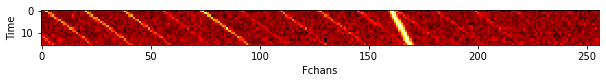

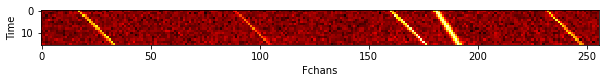

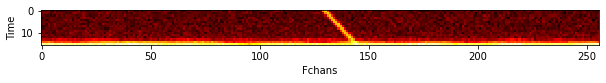

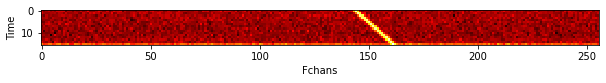

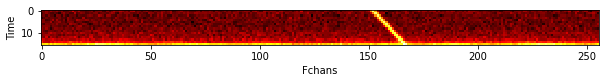

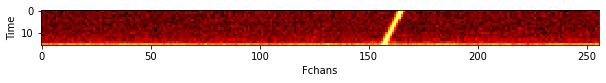

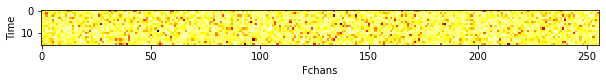

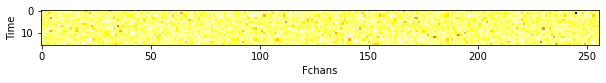

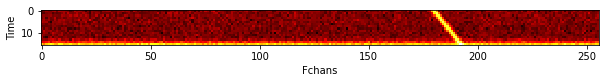

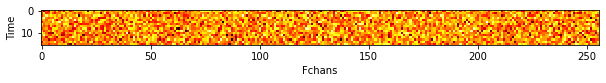

In [6]:
%matplotlib inline
import random 
for i in range(10):
    index = int(random.random()*10000)
    plot_data = data[index:index+1,1,:,:]
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(plot_data[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 1*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [8]:
from tensorflow.python.client import device_lib
gpus = tf.config.experimental.list_physical_devices('GPU')

In [9]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
def sample_creation(inputs):
    z_mean = inputs[0]
    z_log_var = inputs[1]
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [22]:
def build_model():
    latent_dim = 10
    dens_lay = 1024
    kernel = (3,3)
    conv1 = 2
    conv2 = 2
    conv3 = 2
    conv4 = 2
    
    encoder_inputs = keras.Input(shape=(16, 256, 1))
    x = layers.BatchNormalization()(encoder_inputs)
    x = layers.Conv2D(16, kernel, activation="relu", strides=2, padding="same")(x)
    for i in range(conv1):
        x = layers.Conv2D(16, kernel, activation="relu", strides=1, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
    x = layers.Conv2D(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    for i in range(conv2):
        x = layers.Conv2D(32, kernel, activation="relu", strides=1, padding="same")(x)
        x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(64, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    for i in range(conv3):
        x = layers.Conv2D(64, kernel, activation="relu", strides=1, padding="same")(x)
        x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(128, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    for i in range(conv4):
        x = layers.Conv2D(128, kernel, activation="relu", strides=1, padding="same")(x)
        x = layers.BatchNormalization()(x)
    
    
#     x = layers.Conv2D(256, kernel, activation="relu", strides=2, padding="same")(x)
#     x = layers.BatchNormalization()(x)
    
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(dens_lay, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(dens_lay, activation="relu")(latent_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1 * 16 * 128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Reshape((1, 16, 128))(x)
    
    x = layers.Conv2DTranspose(128, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    for i in range(conv4):
        x = layers.Conv2DTranspose(128, kernel, activation="relu", strides=1, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
    
    for i in range(conv3):
        x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=1, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
    x = layers.Conv2DTranspose(64, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    for i in range(conv2):
        x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=1, padding="same")(x)
        x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(32, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    for i in range(conv1):
        x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=1, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
    x = layers.Conv2DTranspose(16, kernel, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    decoder_outputs = layers.Conv2DTranspose(1, kernel, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(lr=0.0005))
    return vae

strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    model = build_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 16, 256, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization_64 (BatchNo (None, 16, 256, 1)   4           in

In [ ]:
model.fit(data[:,:,:,:],data[:,:,:,:], epochs=4000, batch_size=3000)

Epoch 1/4000
20/20 [==============================] - 6s 298ms/step - loss: 802.3581 - reconstruction_loss: 797.9539 - kl_loss: 4.7163
Epoch 2/4000
20/20 [==============================] - 6s 298ms/step - loss: 806.5094 - reconstruction_loss: 797.0255 - kl_loss: 4.5886
Epoch 3/4000
20/20 [==============================] - 6s 298ms/step - loss: 801.9825 - reconstruction_loss: 796.8406 - kl_loss: 4.4661
Epoch 4/4000
20/20 [==============================] - 6s 297ms/step - loss: 798.6641 - reconstruction_loss: 797.0699 - kl_loss: 4.3029
Epoch 5/4000
20/20 [==============================] - 6s 300ms/step - loss: 802.1190 - reconstruction_loss: 798.5397 - kl_loss: 4.1128
Epoch 6/4000
20/20 [==============================] - 6s 306ms/step - loss: 803.6490 - reconstruction_loss: 797.5972 - kl_loss: 4.0382
Epoch 7/4000
20/20 [==============================] - 6s 305ms/step - loss: 803.1063 - reconstruction_loss: 796.6860 - kl_loss: 3.9613
Epoch 8/4000
20/20 [==============================] - 6

In [ ]:
for i in range(200):
    index = int(random.random()*6)
    print(index)
    print(i)
    model.fit(data1[:,index,:,:,:],data1[:,3,:,:,:], epochs=1, batch_size=3000)
    model.encoder.save("VAE-ENCODERv6.h5")
    model.decoder.save("VAE-DECODERv6.h5")

3
0
94/94 [==============================] - 27s 161ms/step - loss: 1789.5096 - reconstruction_loss: 997.7210 - kl_loss: 9.6840
5
1
94/94 [==============================] - 15s 153ms/step - loss: 389.6526 - reconstruction_loss: 383.3987 - kl_loss: 0.8229
3
2
94/94 [==============================] - 15s 151ms/step - loss: 372.6694 - reconstruction_loss: 369.7106 - kl_loss: 2.1884
3
3
94/94 [==============================] - 14s 149ms/step - loss: 370.2573 - reconstruction_loss: 368.3455 - kl_loss: 1.4991
5
4
94/94 [==============================] - 14s 146ms/step - loss: 369.2640 - reconstruction_loss: 367.8070 - kl_loss: 1.0820
2
5
94/94 [==============================] - 15s 156ms/step - loss: 368.4224 - reconstruction_loss: 367.5175 - kl_loss: 0.6878
2
6
94/94 [==============================] - 14s 146ms/step - loss: 367.7091 - reconstruction_loss: 367.1435 - kl_loss: 0.4587
1
7
94/94 [==============================] - 14s 146ms/step - loss: 367.3024 - reconstruction_loss: 366.8592 -

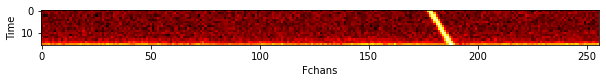

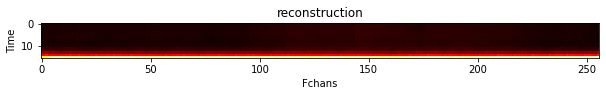

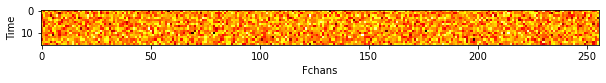

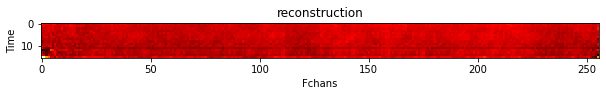

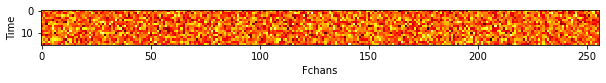

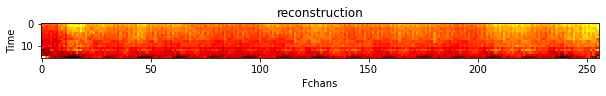

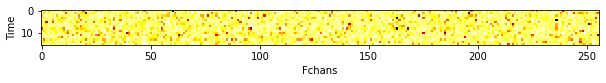

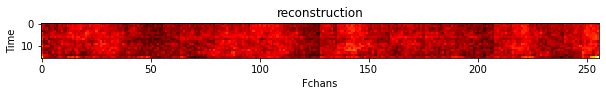

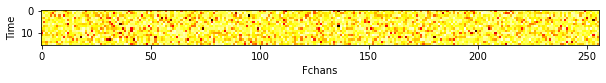

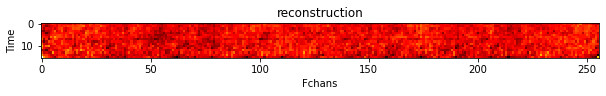

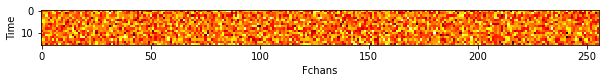

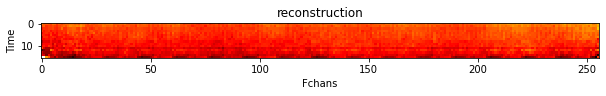

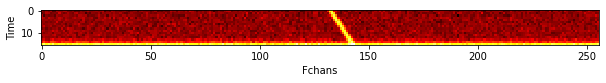

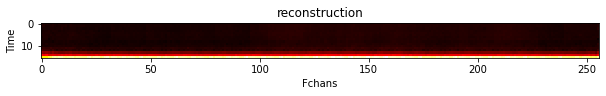

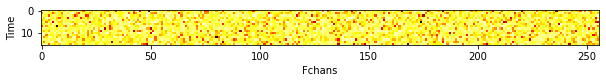

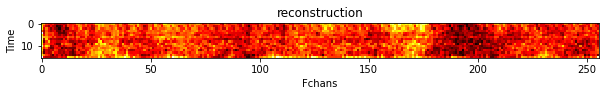

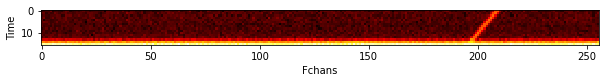

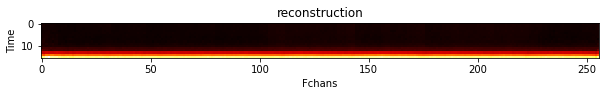

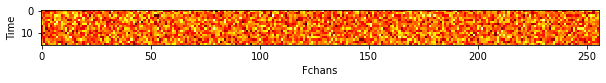

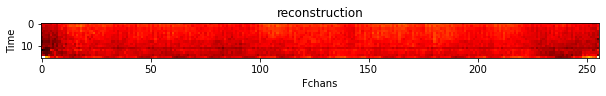

In [16]:
%matplotlib inline
import random 
for i in range(10):
    index = int(random.random()*10000)
    plot_data = data[index:index+1,1,:,:]
    plt.figure(figsize=(10,4))
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(plot_data[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
    plt.show()
    
#     plt.figure(figsize=(10,4))
#     plt.xlabel("Fchans")
#     plt.ylabel("Time")
#     plt.imshow(data1[index,3,:,:], interpolation='nearest', cmap=plt.get_cmap('hot'))
#     plt.show()
    
  
    stuff = model.encoder.predict(plot_data)
    sample = sample_creation(stuff)
    reconstruction = model.decoder.predict(sample)
    plt.figure(figsize=(10,4))
    plt.title("reconstruction")
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(reconstruction[0,:,:,0], interpolation='nearest', cmap=plt.get_cmap('hot'))
#     print("-----------------------------------------------")

In [ ]:
model.encoder.save("VAE-ENCODERv5.h5")
model.decoder.save("VAE-DECODERv5.h5")

In [ ]:
%matplotlib inline
import random

for i in range(10):
    sample = np.array([[1,i,1,1,1,1]]) 
    reconstruction = model.decoder.predict(sample)
    print(reconstruction.max())
    plt.figure(figsize=(10,4))
    plt.title("Reconstruction")
    plt.xlabel("Fchans")
    plt.ylabel("Time")
    plt.imshow(reconstruction[0,:,:,0], interpolation='nearest')

In [ ]:
model.encoder.save("VAE-ENCODER_newtraining.h5")
model.decoder.save("VAE-DECODER_newtraining.h5")

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 16
    scale = 10
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi, 1,1]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)